In [314]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

prices = pd.read_excel('data/generated_average_prices.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

According to 'The Demand for Expert Opinion: Bordeaux Wine', some important factors are:
- Age of Wine
- Average temperature in the summer (Apr-Sep)
- Harvest rain (Aug-Sep)
- Winter rain (Oct-Mar)

We are going to try and recreate the results of the regression that was run in the paper.

# Feature engineering - recreating the experiment

In [320]:
y = prices.set_index('Vintage', drop=True)
y['Log Price'] = np.log(y['Price'])

X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12

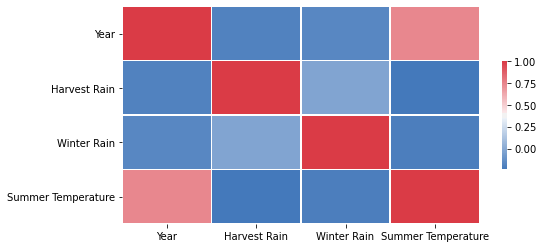

In [321]:
corr = X.reset_index().corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

# Building the model

In [329]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(normalize=False)
oldest_vintage=1950
newest_vintage=1980

y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X_ex, y_ex)
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[i])
print('Total: ',model.score(X_ex,y_ex))

Year -0.038896821882376316
Harvest Rain -0.0012086551317580002
Winter Rain 0.0005620921563760735
Summer Temperature 0.08181432063246365
Total:  0.5543329688907085


This score is quite good, but not as impressive as in the first experiment. This could be due to several factors: the prices were not gathered the same way, the corpus of wines is different, the prices have changed since the experiment. Let us now try to see how this modelss result have changed over time.

In [540]:
def model_tester(X, y):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    scores = []
    for column in coefficients:
        oldest_vintage = column
        newest_vintage = column + 30

        y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
        X_ex = pd.DataFrame(StandardScaler().fit_transform(X_ex), index=X_ex.index, columns=X_ex.columns)

        model.fit(X_ex,y_ex)
        coefs = pd.Series(model.coef_)
        coefs.index = coefficients.index
        coefficients[column] = coefs
        scores.append(model.score(X_ex,y_ex))
    
    coefficients = coefficients.transpose()
    display(coefficients.head())
    return coefficients, scores

,Year,Harvest Rain,Winter Rain,Summer Temperature,Late Summer Temperature
1950,-0.429305,-0.059688,-0.028506,-0.061194,0.230038
1951,-0.353090,-0.031178,0.057843,0.014752,0.239760
1952,-0.326816,-0.038775,0.034598,0.026259,0.249113
1953,-0.351810,-0.060681,0.065374,0.067678,0.195662
1954,-0.331140,-0.053582,0.055490,0.064244,0.211178


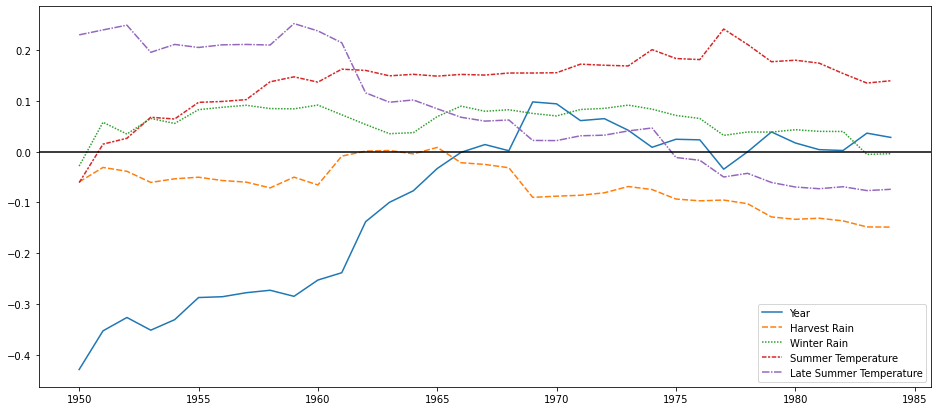

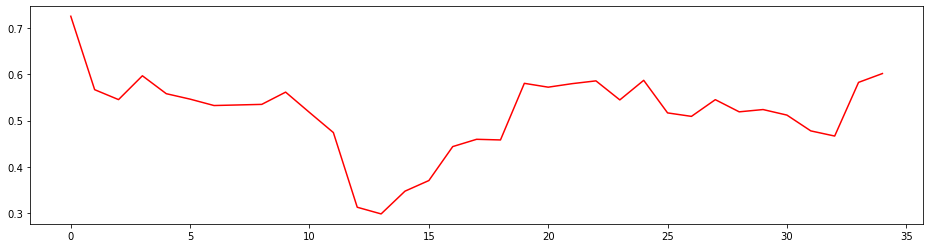

Average score over the whole period:  0.5167586598217081


In [541]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients).axhline(0., color='black')
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Adding new variables

In [473]:
y = prices.set_index('Vintage', drop=True)
y['Log Price'] = np.log(y['Price'])

X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] = precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou'] + precipitations['Sep']
X['Spring Rain'] = precipitations['Mar']+precipitations['Avr']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Insulation'] = insulation.iloc[:,0]

X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])+\
    (temp_maximals['Mar'] + temp_minimals['Mar'])
X['Early Summer Temperature'] = \
    (temp_maximals['Avr'] + temp_minimals['Avr']) +\
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui']) +\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])

X['Frost Days Winter'] = frost_days.shift(1)['Nov']+frost_days.shift(1)['Dec'] + frost_days['Jan']
X['Frost Days Early'] = frost_days['Fev']+frost_days['Mar']
X['Frost Days Late'] = frost_days['Avr']+ 2*(frost_days['Mai'] + frost_days['Jui'] + frost_days['Juil'])

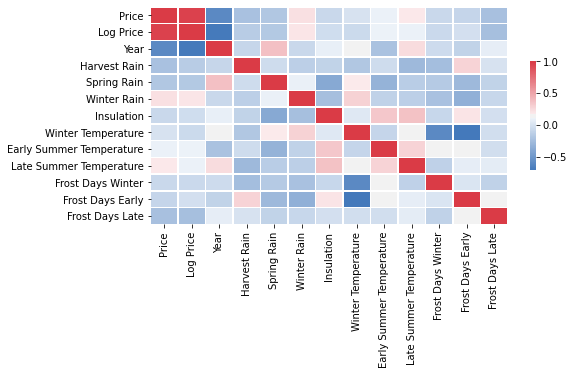

In [474]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex, X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

,Year,Harvest Rain,Spring Rain,Winter Rain,Insulation,Winter Temperature,Early Summer Temperature,Late Summer Temperature,Frost Days Winter,Frost Days Early,Frost Days Late
1950,-0.403148,-0.088540,0.036882,0.053040,0.013982,-0.256852,-0.038199,0.173829,-0.183917,-0.171288,-0.093320
1951,-0.308965,-0.092523,-0.039863,0.060369,-0.029326,-0.378738,0.045015,0.149921,-0.312178,-0.286452,-0.128025
1952,-0.307980,-0.092141,-0.043533,0.049280,-0.011164,-0.366192,0.038490,0.144965,-0.311223,-0.288260,-0.125069
1953,-0.364927,-0.108425,-0.023257,0.065991,-0.070309,-0.200801,0.116682,0.103530,-0.203452,-0.163036,-0.086296
1954,-0.341873,-0.108806,-0.017307,0.050857,-0.048310,-0.254165,0.108426,0.099829,-0.235361,-0.206118,-0.092492


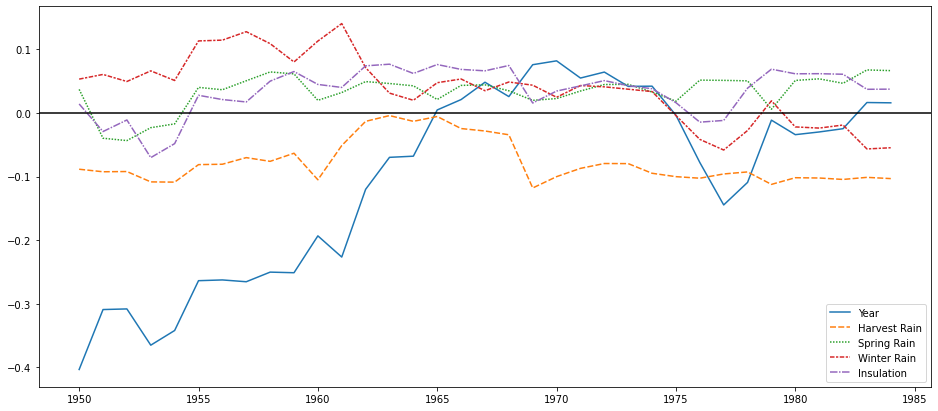

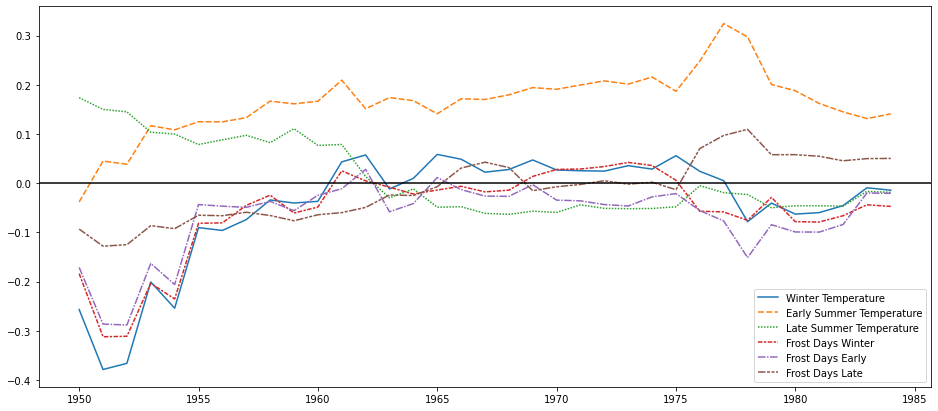

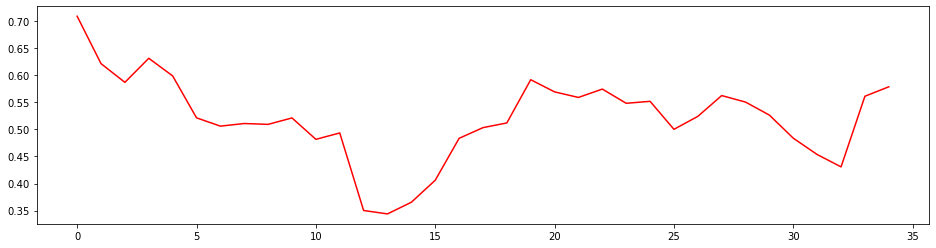

Average score over the whole period:  0.520667689663526


In [475]:
coefficients, scores = model_tester(X,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))

This is better, but there is too many features: 11 features for predicting a 30 dimensional vector.
Let us rank the features according to their average importance.

In [476]:
df = coefficients
rank = np.mean(np.abs(df)).to_frame()
rank.columns = ['Importance']
rank = rank.sort_values('Importance', ascending=False)
display(rank)

,Importance
Early Summer Temperature,0.166349
Year,0.132123
Harvest Rain,0.077704
Winter Temperature,0.076907
Frost Days Early,0.071212
Frost Days Winter,0.069205
Late Summer Temperature,0.062726
Winter Rain,0.055192
Frost Days Late,0.052358
Insulation,0.044755


In [594]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2

X['Winter Rain'] =  precipitations.shift(1)['Dec']

#X['Winter Temperature'] = \
#    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
#    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
#    (temp_maximals['Fev'] + temp_minimals['Fev'])


X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


#X['Frost Days'] = frost_days['Mar']+ 2*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

,Year,Harvest Rain,Winter Rain,Summer Temperature,Late Summer Temperature
1950,-0.425698,-0.048364,-0.016360,-0.049877,0.232064
1951,-0.346728,-0.043099,0.109088,0.005541,0.214187
1952,-0.322961,-0.051774,0.106913,0.014239,0.220133
1953,-0.341699,-0.067030,0.108644,0.050671,0.174467
1954,-0.333093,-0.070456,0.099120,0.048920,0.189480


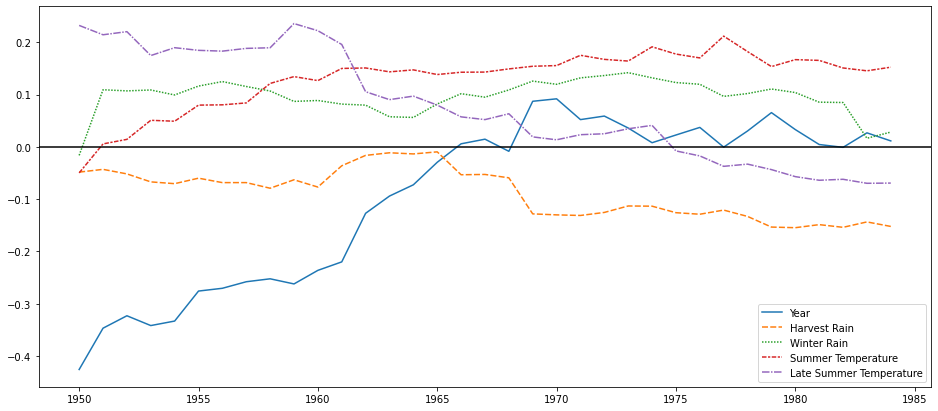

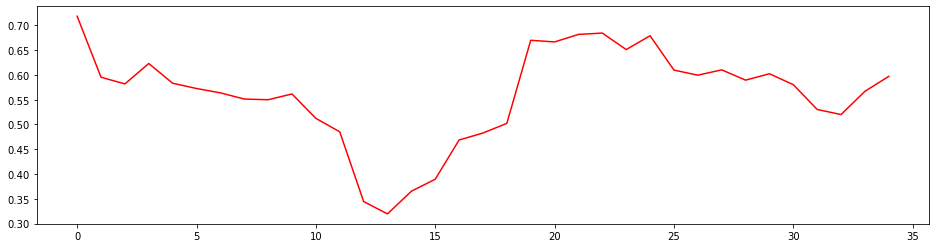

Average score over the whole period:  0.5602449201273495


In [595]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))

## Showing feature evolution through time

,Harvest Rain,Summer Rain,Winter Rain,Insulation,Winter Temperature,Early Summer Temperature,Late Summer Temperature,Frost Days Winter,Frost Days Early,Frost Days Late
Year,,,,,,,,,,
1949,90.2,189.3,NaN,2236,NaN,135.2,84.8,NaN,23,1
1950,135.3,181.3,566.8,2011,39.6,136.4,71.9,28.0,10,1
1951,177.0,294.3,746.0,1653,34.9,122.9,72.0,23.0,13,1
1952,165.5,155.9,566.4,1929,32.7,137.4,70.2,29.0,16,3
1953,75.6,224.3,653.3,2055,26.2,127.1,76.4,35.0,19,1


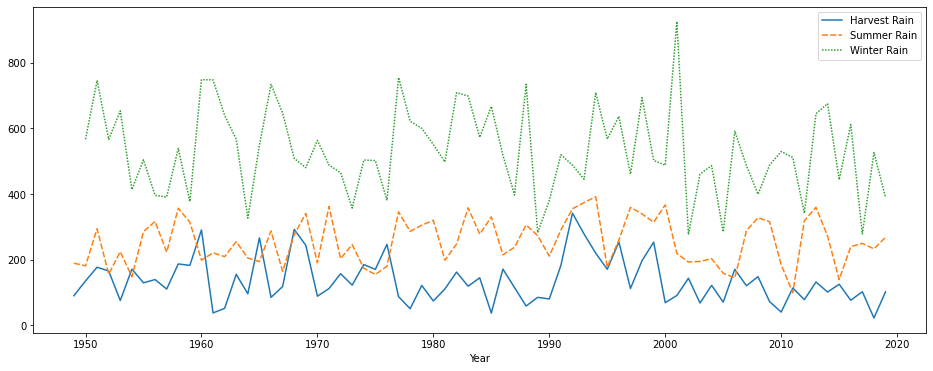

In [206]:
display(X.head())
plt.figure(figsize=(16,6))
sns.lineplot(data=X[['Harvest Rain','Summer Rain','Winter Rain']])
plt.show()

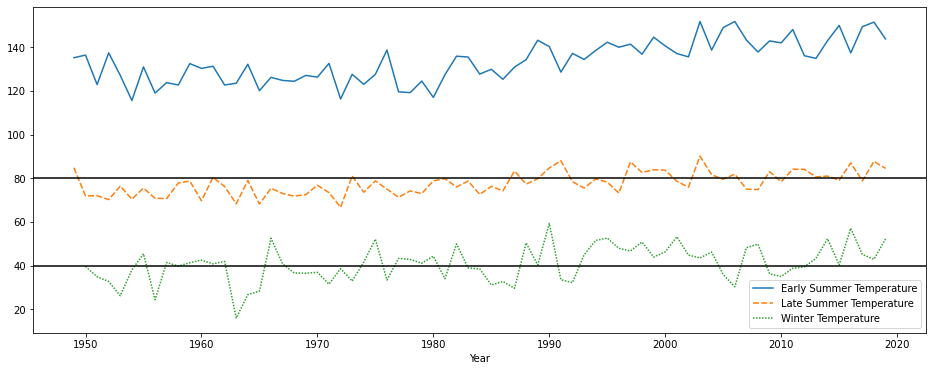

In [236]:
plt.figure(figsize=(16,6))
graph = sns.lineplot(data=X[['Early Summer Temperature','Late Summer Temperature','Winter Temperature']])
graph.axhline(80, color='black')
graph.axhline(40, color='black')
plt.show()

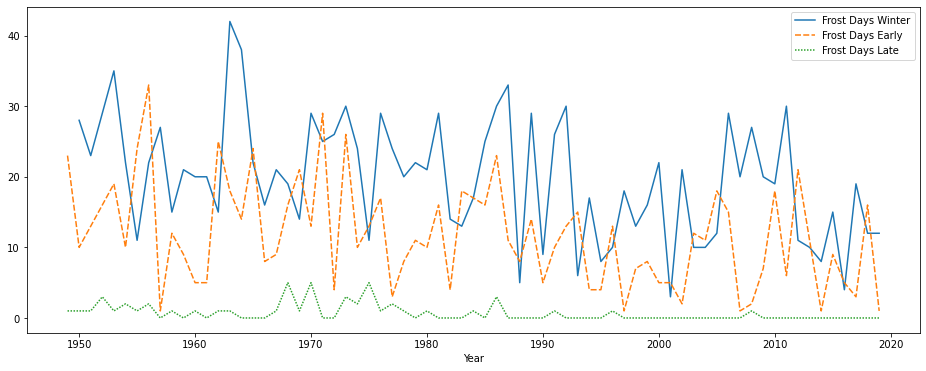

In [230]:
plt.figure(figsize=(16,6))
sns.lineplot(data=X[['Frost Days Winter','Frost Days Early','Frost Days Late']])
plt.show()

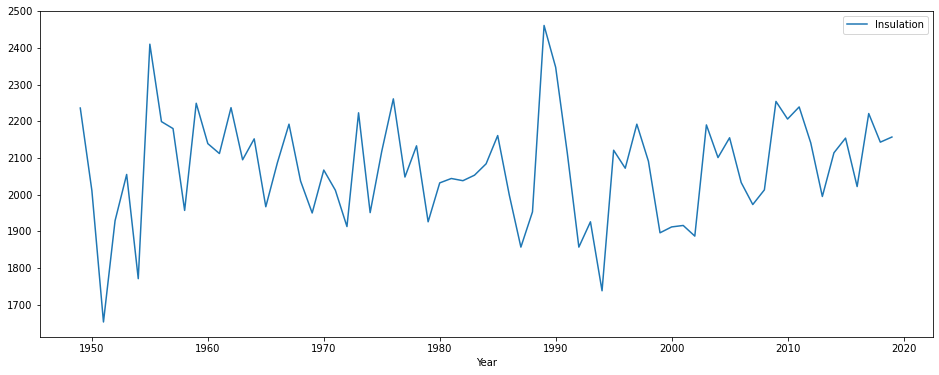

In [222]:
plt.figure(figsize=(16,6))
sns.lineplot(data=X[['Insulation']])
plt.show()

While hoping to see squared relations out of these graphs, nothing obvious appears here, except that the frequent late frosts of the 70s were probably accountable for the low quality of wines at that time.

# Trying PCA

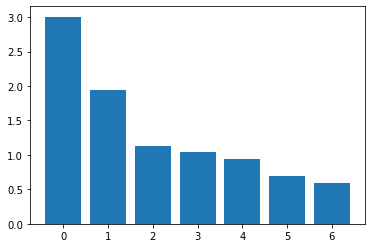

[[ 0.21785815 -0.06497102 -0.02736722 -0.13929    -0.4476501  -0.41089158
  -0.42309716  0.39091469  0.3403105   0.33362657]
 [ 0.28323141  0.30484864  0.47952774 -0.49804787  0.29923292 -0.26051763
  -0.2434153  -0.26469688 -0.24617178  0.0390253 ]
 [-0.28897819 -0.60035325  0.25385306  0.26059387  0.29209975 -0.18430185
  -0.17258803 -0.1703872  -0.12883846  0.47854972]
 [-0.53664355  0.45593748  0.34995282  0.25493061 -0.08787521 -0.29376436
   0.06494599 -0.17335698  0.43007018 -0.05854564]
 [ 0.45984459  0.19645862 -0.28562342  0.23887533  0.20132889  0.07218716
   0.07688721 -0.47406253  0.40089969  0.41736435]
 [ 0.16874901 -0.40638783  0.49927577 -0.19681272 -0.2547302   0.4039615
   0.07824601 -0.21699988  0.45161473 -0.18199325]
 [-0.17150523  0.09828169  0.07624794 -0.41408717 -0.07218131  0.09621956
   0.63012809  0.19612311 -0.02133342  0.57723096]]


In [246]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)



pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

In [247]:
model = LinearRegression(normalize=False)

oldest_vintage=1951
newest_vintage=1980

X2 = X2.loc[oldest_vintage:newest_vintage]
y_ex = y.loc[X2.index,:].reset_index(drop=True)
X_ex = X2.reset_index()
model.fit(X_ex,y_ex)

print(len(y_ex),len(X_ex))
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[0][i])
print('Total: ',model.score(X_ex,y_ex))

30 30
Year -14.285582527513732
0 -8.4769454919004
1 -2.1332237409463484
2 -3.5009001875357826
3 -1.0838132161853813
4 -0.9686683718386704
5 3.782489068739957
6 0.7178503617420289
Total:  0.5259834662417557
